# Import

In [1]:

# Import Library
import torch
torch.cuda.empty_cache()
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import models,transforms

from collections import namedtuple

from sklearn.metrics import classification_report

import time

# Get DATA

In [2]:
# Using CUDA
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
else: print("Using CPU")

Using CUDA


In [3]:
# Clone Data
!git clone https://github.com/qcuong103/echocardiography

# Hyper-parameters
classes = ['2C', '3C', '4C']
TrainTest = namedtuple('TrainTest', ['train', 'test'])

Cloning into 'echocardiography'...
remote: Enumerating objects: 8335, done.
remote: Total 8335 (delta 0), reused 0 (delta 0), pack-reused 8335
Receiving objects: 100% (8335/8335), 488.10 MiB | 28.33 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (8327/8327), done.


# Prepare Data

In [4]:
# Transforms Data
def prepare_data(sizeImg=224, typeImg="None"):
  if (typeImg == "None"):
    if (sizeImg == 224):
      transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])
      transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])
    elif (sizeImg == 64):
      transform_train = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()])
      transform_test = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()])
    else:
      transform_train = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()])
      transform_test = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()])
  elif (typeImg == "aug"):
    transform_train = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=10),
      transforms.ToTensor()])
    transform_test = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor()])
  else:
    transform_train = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomEqualize(p=1),
      transforms.GaussianBlur(kernel_size=3),
      transforms.ToTensor()])
    transform_test = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomEqualize(p=1),
      transforms.GaussianBlur(kernel_size=3),
      transforms.ToTensor()])
    
  trainset = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/train', 
      transform=transform_train)
  testset = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/test', 
      transform=transform_test)
  
  print("Number of Image in train set:", len(trainset))
  print("Number of Image in test set:", len(testset))

  return TrainTest(train=trainset,test=testset)

# Load Data
def prepare_loader(datasets):
  batch_size = 32
  trainloader = DataLoader(
    dataset=datasets.train, batch_size=batch_size, 
    shuffle=True, num_workers=4
  )
  testloader = DataLoader(
    dataset=datasets.test, batch_size=batch_size, 
    shuffle=True, num_workers=4
  )
  
  print("Num batch in train set: ", len(trainloader))
  print("Num batch in test set: ", len(testloader))
  class_names = datasets.train.classes
  inputs, classes = next(iter(trainloader))
  # show_databatch(inputs, classes)
  for i in range(4):
    print([class_names[x] for x in classes[(8*i):(8*i+8)]])
  imshow(torchvision.utils.make_grid(inputs))
  return TrainTest(train=trainloader, test=testloader)

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# dataset = prepare_data()
# loaderset = prepare_loader(dataset)

In [5]:
torch.__version__

'1.10.0+cu111'

# **Train**

In [6]:
def train_epoch(epoch, model, loader, loss_func, optimizer, device):
  print("Train model")
  print('-' * 10)
  model.train()
  running_loss = 0.0
  images_so_close = 0.0
  reporting_steps = 60

  for i, (images, labels) in enumerate(loader):
    images, labels = images.to(device), labels.to(device)
    
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()

    images_so_close = loss.item()
    running_loss += images_so_close
    if i % reporting_steps == reporting_steps - 1:
      print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_steps:.4f}")
      running_loss = 0.0
  return images_so_close


# **Test**

In [7]:
def test_epoch(epoch, model, loader, device):
  since = time.time()

  model.eval()
  ytrue = []
  ypred = []

  print("Test model")
  print('-' * 10)

  for i, (images, labels) in enumerate(loader):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, dim=1)
    ytrue += list(labels.cpu().numpy())
    ypred += list(predicted.cpu().numpy())

  elapsed_time = time.time() - since
  print()
  print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
  print('-' * 10)

  return ypred, ytrue

# **Main**

In [8]:
def run(modelName, imgSize, aug):
  PATH = "./" + modelName + '.pth'
  datasets = prepare_data(imgSize, aug)
  loaders = prepare_loader(datasets)
  use_pretrained = False
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("image size: ", datasets.train[0][0].shape)
  print("device:", device)
  print("model:", modelName)
  
  if modelName == 'vgg16':
    model = models.vgg16(pretrained=use_pretrained)
    model.classifier[6] = nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
  elif modelName == 'resnet50':
    model = models.resnet50(pretrained=use_pretrained)
    model.fc = nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True) 
  elif modelName == 'resnet18':
    model = models.resnet18(pretrained=use_pretrained)
    model.fc = nn.modules.linear.Linear(in_features=512, out_features=3, bias=True)
  else:
    model = models.densenet121(pretrained=use_pretrained)
    model.classifier = nn.modules.linear.Linear(in_features=1024, out_features=3, bias=True)
  model.to(device)

  loss_func = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

  # class_out = len(classes)
  n_epoch = 20

  accuracies = []
  losses = []
  for epoch in range(n_epoch):
    print("---------------------------------------------------------------")
    print(f"\nEpoch {epoch} report: ")
    loss = train_epoch(epoch, model, loaders.train, loss_func, optimizer, device)
    ypred, ytrue = test_epoch(epoch, model, loaders.test, device)

    print("Test report: \n", classification_report(ytrue, ypred, target_names=classes))
    
    torch.save(model.state_dict(), PATH)

    ypred = np.array(ypred)
    ytrue = np.array(ytrue)
    accuracy = int((ytrue==ypred).sum() / len(ytrue) * 100)
    accuracies.append(accuracy)
    losses.append(round(loss, 4))

  print("model:", modelName, ", size:", imgSize, ", augmentation:", aug)
  print("accr: ", accuracies)
  print("loss: ", losses)
  return model

# **Run**

Number of Image in train set: 6717
Number of Image in test set: 1607
Num batch in train set:  210
Num batch in test set:  51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['3C', '3C', '2C', '4C', '3C', '2C', '2C', '3C']
['2C', '2C', '3C', '3C', '2C', '2C', '4C', '2C']
['3C', '3C', '4C', '2C', '4C', '2C', '2C', '2C']
['2C', '2C', '2C', '3C', '3C', '2C', '2C', '3C']


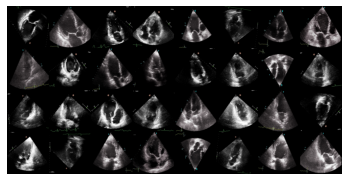

image size:  torch.Size([3, 224, 224])
device: cuda
model: vgg16
---------------------------------------------------------------

Epoch 0 report: 
Train model
----------
Epoch 0 Step 59 ave_loss 1.0964
Epoch 0 Step 119 ave_loss 1.0864
Epoch 0 Step 179 ave_loss 1.0604
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.74      0.07      0.13       409
          3C       0.34      1.00      0.51       367
          4C       1.00      0.61      0.76       831

    accuracy                           0.56      1607
   macro avg       0.69      0.56      0.46      1607
weighted avg       0.78      0.56      0.54      1607

---------------------------------------------------------------

Epoch 1 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Step 59 ave_loss 0.9633
Epoch 1 Step 119 ave_loss 0.8329
Epoch 1 Step 179 ave_loss 0.7950
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.58      0.74      0.65       409
          3C       0.65      0.82      0.72       367
          4C       0.99      0.74      0.84       831

    accuracy                           0.75      1607
   macro avg       0.74      0.76      0.74      1607
weighted avg       0.80      0.75      0.77      1607

---------------------------------------------------------------

Epoch 2 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Step 59 ave_loss 0.5835
Epoch 2 Step 119 ave_loss 0.5376
Epoch 2 Step 179 ave_loss 0.4324
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.54      0.92      0.68       409
          3C       0.71      0.68      0.70       367
          4C       0.99      0.66      0.80       831

    accuracy                           0.73      1607
   macro avg       0.75      0.76      0.72      1607
weighted avg       0.81      0.73      0.74      1607

---------------------------------------------------------------

Epoch 3 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Step 59 ave_loss 0.3419
Epoch 3 Step 119 ave_loss 0.3696
Epoch 3 Step 179 ave_loss 0.2299
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.56      0.90      0.69       409
          3C       0.73      0.63      0.68       367
          4C       0.93      0.71      0.81       831

    accuracy                           0.74      1607
   macro avg       0.74      0.75      0.72      1607
weighted avg       0.79      0.74      0.75      1607

---------------------------------------------------------------

Epoch 4 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Step 59 ave_loss 0.1886
Epoch 4 Step 119 ave_loss 0.1238
Epoch 4 Step 179 ave_loss 0.1335
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.58      0.96      0.72       409
          3C       0.92      0.76      0.83       367
          4C       0.97      0.73      0.83       831

    accuracy                           0.79      1607
   macro avg       0.82      0.82      0.80      1607
weighted avg       0.86      0.79      0.80      1607

---------------------------------------------------------------

Epoch 5 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Step 59 ave_loss 0.1042
Epoch 5 Step 119 ave_loss 0.0984
Epoch 5 Step 179 ave_loss 0.1102
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.55      0.99      0.71       409
          3C       0.81      0.91      0.86       367
          4C       1.00      0.55      0.71       831

    accuracy                           0.75      1607
   macro avg       0.79      0.82      0.76      1607
weighted avg       0.84      0.75      0.74      1607

---------------------------------------------------------------

Epoch 6 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Step 59 ave_loss 0.0634
Epoch 6 Step 119 ave_loss 0.1328
Epoch 6 Step 179 ave_loss 0.0783
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.60      0.99      0.75       409
          3C       0.77      0.87      0.81       367
          4C       1.00      0.62      0.77       831

    accuracy                           0.77      1607
   macro avg       0.79      0.83      0.78      1607
weighted avg       0.85      0.77      0.77      1607

---------------------------------------------------------------

Epoch 7 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Step 59 ave_loss 0.0612
Epoch 7 Step 119 ave_loss 0.0588
Epoch 7 Step 179 ave_loss 0.0808
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.65      0.78      0.71       409
          3C       0.66      0.89      0.76       367
          4C       0.94      0.70      0.80       831

    accuracy                           0.77      1607
   macro avg       0.75      0.79      0.76      1607
weighted avg       0.80      0.77      0.77      1607

---------------------------------------------------------------

Epoch 8 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Step 59 ave_loss 0.0706
Epoch 8 Step 119 ave_loss 0.0510
Epoch 8 Step 179 ave_loss 0.0749
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.69      0.93      0.79       409
          3C       0.66      0.98      0.79       367
          4C       1.00      0.61      0.76       831

    accuracy                           0.77      1607
   macro avg       0.78      0.84      0.78      1607
weighted avg       0.84      0.77      0.77      1607

---------------------------------------------------------------

Epoch 9 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Step 59 ave_loss 0.0532
Epoch 9 Step 119 ave_loss 0.0360
Epoch 9 Step 179 ave_loss 0.0380
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.66      0.99      0.79       409
          3C       0.61      0.87      0.72       367
          4C       0.96      0.54      0.69       831

    accuracy                           0.73      1607
   macro avg       0.74      0.80      0.73      1607
weighted avg       0.80      0.73      0.72      1607

---------------------------------------------------------------

Epoch 10 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Step 59 ave_loss 0.0468
Epoch 10 Step 119 ave_loss 0.0469
Epoch 10 Step 179 ave_loss 0.0545
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.66      0.89      0.75       409
          3C       0.67      0.90      0.76       367
          4C       0.94      0.63      0.76       831

    accuracy                           0.76      1607
   macro avg       0.75      0.81      0.76      1607
weighted avg       0.80      0.76      0.76      1607

---------------------------------------------------------------

Epoch 11 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Step 59 ave_loss 0.0339
Epoch 11 Step 119 ave_loss 0.0247
Epoch 11 Step 179 ave_loss 0.0565
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.76      0.90      0.82       409
          3C       0.71      0.94      0.81       367
          4C       0.97      0.74      0.84       831

    accuracy                           0.83      1607
   macro avg       0.81      0.86      0.82      1607
weighted avg       0.86      0.83      0.83      1607

---------------------------------------------------------------

Epoch 12 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Step 59 ave_loss 0.0608
Epoch 12 Step 119 ave_loss 0.0322
Epoch 12 Step 179 ave_loss 0.0396
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.72      0.88      0.79       409
          3C       0.75      0.95      0.83       367
          4C       0.99      0.76      0.86       831

    accuracy                           0.84      1607
   macro avg       0.82      0.86      0.83      1607
weighted avg       0.87      0.84      0.84      1607

---------------------------------------------------------------

Epoch 13 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Step 59 ave_loss 0.0151
Epoch 13 Step 119 ave_loss 0.0068
Epoch 13 Step 179 ave_loss 0.0011
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.67      0.99      0.80       409
          3C       0.87      0.87      0.87       367
          4C       0.97      0.74      0.84       831

    accuracy                           0.83      1607
   macro avg       0.84      0.87      0.84      1607
weighted avg       0.87      0.83      0.84      1607

---------------------------------------------------------------

Epoch 14 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Step 59 ave_loss 0.0359
Epoch 14 Step 119 ave_loss 0.0288
Epoch 14 Step 179 ave_loss 0.0162
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.74      0.99      0.85       409
          3C       0.81      0.86      0.83       367
          4C       0.97      0.78      0.87       831

    accuracy                           0.85      1607
   macro avg       0.84      0.88      0.85      1607
weighted avg       0.87      0.85      0.85      1607

---------------------------------------------------------------

Epoch 15 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Step 59 ave_loss 0.0115
Epoch 15 Step 119 ave_loss 0.0196
Epoch 15 Step 179 ave_loss 0.0116
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.51      0.95      0.67       409
          3C       0.91      0.89      0.90       367
          4C       0.99      0.59      0.74       831

    accuracy                           0.75      1607
   macro avg       0.81      0.81      0.77      1607
weighted avg       0.85      0.75      0.76      1607

---------------------------------------------------------------

Epoch 16 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Step 59 ave_loss 0.0233
Epoch 16 Step 119 ave_loss 0.0164
Epoch 16 Step 179 ave_loss 0.0196
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.79      0.82      0.80       409
          3C       0.72      0.96      0.83       367
          4C       0.97      0.80      0.88       831

    accuracy                           0.85      1607
   macro avg       0.83      0.86      0.84      1607
weighted avg       0.87      0.85      0.85      1607

---------------------------------------------------------------

Epoch 17 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Step 59 ave_loss 0.0093
Epoch 17 Step 119 ave_loss 0.0270
Epoch 17 Step 179 ave_loss 0.0177
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.79      0.95      0.87       409
          3C       0.70      0.96      0.81       367
          4C       0.99      0.73      0.84       831

    accuracy                           0.84      1607
   macro avg       0.83      0.88      0.84      1607
weighted avg       0.87      0.84      0.84      1607

---------------------------------------------------------------

Epoch 18 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Step 59 ave_loss 0.0143
Epoch 18 Step 119 ave_loss 0.0055
Epoch 18 Step 179 ave_loss 0.0037
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.72      0.99      0.83       409
          3C       0.71      0.89      0.79       367
          4C       0.97      0.67      0.79       831

    accuracy                           0.80      1607
   macro avg       0.80      0.85      0.80      1607
weighted avg       0.84      0.80      0.80      1607

---------------------------------------------------------------

Epoch 19 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Step 59 ave_loss 0.0215
Epoch 19 Step 119 ave_loss 0.0176
Epoch 19 Step 179 ave_loss 0.0218
Test model
----------

Evaluation completed in 0m 16s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.73      0.95      0.83       409
          3C       0.83      0.94      0.88       367
          4C       0.99      0.79      0.88       831

    accuracy                           0.86      1607
   macro avg       0.85      0.89      0.86      1607
weighted avg       0.89      0.86      0.87      1607

model: vgg16 , size: 224 , augmentation: aug
accr:  [55, 75, 73, 73, 79, 74, 77, 76, 77, 73, 75, 82, 83, 83, 85, 74, 84, 84, 80, 86]
loss:  [0.9579, 0.4552, 0.5349, 0.1296, 0.0796, 0.1106, 0.0222, 0.1708, 0.0425, 0.1125, 0.0103, 0.0004, 0.0034, 0.1488, 0.007, 0.0168, 0.0324, 0.0001, 0.0, 0.0017]
Number of Image in train set: 6717
Number of Image in test set: 1607
Num batch in train set:  210
Num batch in test set:  51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['2C', '3C', '3C', '4C', '2C', '2C', '4C', '3C']
['4C', '4C', '2C', '4C', '4C', '3C', '4C', '2C']
['4C', '2C', '2C', '2C', '2C', '4C', '2C', '4C']
['2C', '4C', '4C', '4C', '4C', '3C', '4C', '3C']


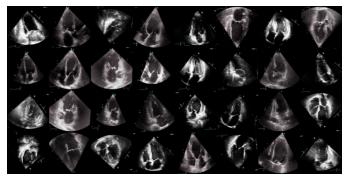

image size:  torch.Size([3, 224, 224])
device: cuda
model: resnet18
---------------------------------------------------------------

Epoch 0 report: 
Train model
----------
Epoch 0 Step 59 ave_loss 1.0716
Epoch 0 Step 119 ave_loss 0.8676
Epoch 0 Step 179 ave_loss 0.5676
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       1.00      0.09      0.17       409
          3C       0.67      0.14      0.24       367
          4C       0.56      1.00      0.72       831

    accuracy                           0.57      1607
   macro avg       0.74      0.41      0.37      1607
weighted avg       0.70      0.57      0.47      1607

---------------------------------------------------------------

Epoch 1 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Step 59 ave_loss 0.4732
Epoch 1 Step 119 ave_loss 0.3298
Epoch 1 Step 179 ave_loss 0.2819
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.56      0.70      0.62       409
          3C       1.00      0.16      0.27       367
          4C       0.65      0.81      0.72       831

    accuracy                           0.63      1607
   macro avg       0.74      0.56      0.54      1607
weighted avg       0.71      0.63      0.59      1607

---------------------------------------------------------------

Epoch 2 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Step 59 ave_loss 0.1646
Epoch 2 Step 119 ave_loss 0.1422
Epoch 2 Step 179 ave_loss 0.1628
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.62      0.85      0.72       409
          3C       0.86      0.34      0.49       367
          4C       0.77      0.82      0.79       831

    accuracy                           0.72      1607
   macro avg       0.75      0.67      0.67      1607
weighted avg       0.75      0.72      0.70      1607

---------------------------------------------------------------

Epoch 3 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Step 59 ave_loss 0.1778
Epoch 3 Step 119 ave_loss 0.1016
Epoch 3 Step 179 ave_loss 0.0767
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       1.00      0.34      0.51       409
          3C       0.29      1.00      0.45       367
          4C       1.00      0.24      0.38       831

    accuracy                           0.44      1607
   macro avg       0.76      0.53      0.45      1607
weighted avg       0.84      0.44      0.43      1607

---------------------------------------------------------------

Epoch 4 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Step 59 ave_loss 0.0449
Epoch 4 Step 119 ave_loss 0.0413
Epoch 4 Step 179 ave_loss 0.0448
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.76      0.69      0.72       409
          3C       0.85      0.16      0.27       367
          4C       0.70      0.97      0.81       831

    accuracy                           0.72      1607
   macro avg       0.77      0.61      0.60      1607
weighted avg       0.75      0.72      0.67      1607

---------------------------------------------------------------

Epoch 5 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Step 59 ave_loss 0.0876
Epoch 5 Step 119 ave_loss 0.0654
Epoch 5 Step 179 ave_loss 0.0804
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.97      0.81       409
          3C       0.86      0.85      0.86       367
          4C       0.99      0.81      0.89       831

    accuracy                           0.86      1607
   macro avg       0.85      0.87      0.85      1607
weighted avg       0.88      0.86      0.86      1607

---------------------------------------------------------------

Epoch 6 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Step 59 ave_loss 0.0317
Epoch 6 Step 119 ave_loss 0.0445
Epoch 6 Step 179 ave_loss 0.0261
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.86      0.87      0.86       409
          3C       0.83      0.70      0.76       367
          4C       0.88      0.94      0.90       831

    accuracy                           0.86      1607
   macro avg       0.86      0.83      0.84      1607
weighted avg       0.86      0.86      0.86      1607

---------------------------------------------------------------

Epoch 7 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Step 59 ave_loss 0.0314
Epoch 7 Step 119 ave_loss 0.0181
Epoch 7 Step 179 ave_loss 0.0595
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.69      0.90      0.78       409
          3C       0.89      0.63      0.74       367
          4C       0.84      0.83      0.83       831

    accuracy                           0.80      1607
   macro avg       0.81      0.78      0.78      1607
weighted avg       0.81      0.80      0.80      1607

---------------------------------------------------------------

Epoch 8 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Step 59 ave_loss 0.0703
Epoch 8 Step 119 ave_loss 0.0216
Epoch 8 Step 179 ave_loss 0.0091
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.77      0.95      0.85       409
          3C       0.81      0.81      0.81       367
          4C       0.94      0.83      0.88       831

    accuracy                           0.86      1607
   macro avg       0.84      0.86      0.85      1607
weighted avg       0.87      0.86      0.86      1607

---------------------------------------------------------------

Epoch 9 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Step 59 ave_loss 0.0196
Epoch 9 Step 119 ave_loss 0.0214
Epoch 9 Step 179 ave_loss 0.0115
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.97      0.93      0.95       409
          3C       0.80      0.89      0.84       367
          4C       0.94      0.92      0.93       831

    accuracy                           0.91      1607
   macro avg       0.90      0.91      0.91      1607
weighted avg       0.92      0.91      0.91      1607

---------------------------------------------------------------

Epoch 10 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Step 59 ave_loss 0.0278
Epoch 10 Step 119 ave_loss 0.0275
Epoch 10 Step 179 ave_loss 0.0210
Test model
----------

Evaluation completed in 0m 13s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.75      0.99      0.85       409
          3C       0.77      0.75      0.76       367
          4C       0.91      0.77      0.84       831

    accuracy                           0.82      1607
   macro avg       0.81      0.84      0.81      1607
weighted avg       0.83      0.82      0.82      1607

---------------------------------------------------------------

Epoch 11 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Step 59 ave_loss 0.0220
Epoch 11 Step 119 ave_loss 0.0232
Epoch 11 Step 179 ave_loss 0.0172
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.87      0.93      0.90       409
          3C       0.71      0.86      0.78       367
          4C       0.95      0.83      0.89       831

    accuracy                           0.86      1607
   macro avg       0.84      0.87      0.86      1607
weighted avg       0.88      0.86      0.87      1607

---------------------------------------------------------------

Epoch 12 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Step 59 ave_loss 0.0211
Epoch 12 Step 119 ave_loss 0.0169
Epoch 12 Step 179 ave_loss 0.0173
Test model
----------

Evaluation completed in 0m 13s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.87      0.97      0.91       409
          3C       0.94      0.85      0.89       367
          4C       0.94      0.93      0.94       831

    accuracy                           0.92      1607
   macro avg       0.92      0.92      0.91      1607
weighted avg       0.92      0.92      0.92      1607

---------------------------------------------------------------

Epoch 13 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Step 59 ave_loss 0.0039
Epoch 13 Step 119 ave_loss 0.0236
Epoch 13 Step 179 ave_loss 0.0113
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.90      0.98      0.94       409
          3C       0.78      0.91      0.84       367
          4C       0.96      0.84      0.90       831

    accuracy                           0.89      1607
   macro avg       0.88      0.91      0.89      1607
weighted avg       0.90      0.89      0.89      1607

---------------------------------------------------------------

Epoch 14 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Step 59 ave_loss 0.0019
Epoch 14 Step 119 ave_loss 0.0041
Epoch 14 Step 179 ave_loss 0.0133
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.86      0.72      0.78       409
          3C       0.58      0.93      0.71       367
          4C       0.97      0.79      0.87       831

    accuracy                           0.80      1607
   macro avg       0.80      0.81      0.79      1607
weighted avg       0.85      0.80      0.81      1607

---------------------------------------------------------------

Epoch 15 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Step 59 ave_loss 0.0028
Epoch 15 Step 119 ave_loss 0.0035
Epoch 15 Step 179 ave_loss 0.0056
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.86      0.70      0.77       409
          3C       0.48      0.93      0.63       367
          4C       0.99      0.66      0.79       831

    accuracy                           0.73      1607
   macro avg       0.78      0.76      0.73      1607
weighted avg       0.84      0.73      0.75      1607

---------------------------------------------------------------

Epoch 16 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Step 59 ave_loss 0.0051
Epoch 16 Step 119 ave_loss 0.0150
Epoch 16 Step 179 ave_loss 0.0163
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.98      0.89      0.93       409
          3C       0.84      0.85      0.85       367
          4C       0.90      0.94      0.92       831

    accuracy                           0.91      1607
   macro avg       0.91      0.89      0.90      1607
weighted avg       0.91      0.91      0.91      1607

---------------------------------------------------------------

Epoch 17 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Step 59 ave_loss 0.0048
Epoch 17 Step 119 ave_loss 0.0052
Epoch 17 Step 179 ave_loss 0.0041
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.82      0.84      0.83       409
          3C       0.73      0.89      0.80       367
          4C       0.96      0.86      0.91       831

    accuracy                           0.86      1607
   macro avg       0.84      0.86      0.85      1607
weighted avg       0.87      0.86      0.86      1607

---------------------------------------------------------------

Epoch 18 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Step 59 ave_loss 0.0011
Epoch 18 Step 119 ave_loss 0.0029
Epoch 18 Step 179 ave_loss 0.0025
Test model
----------

Evaluation completed in 0m 13s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.78      0.92      0.85       409
          3C       0.68      0.87      0.76       367
          4C       0.98      0.78      0.86       831

    accuracy                           0.83      1607
   macro avg       0.81      0.85      0.83      1607
weighted avg       0.86      0.83      0.84      1607

---------------------------------------------------------------

Epoch 19 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Step 59 ave_loss 0.0065
Epoch 19 Step 119 ave_loss 0.0272
Epoch 19 Step 179 ave_loss 0.0217
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.65      0.85      0.73       409
          3C       0.67      0.94      0.78       367
          4C       0.97      0.64      0.77       831

    accuracy                           0.76      1607
   macro avg       0.76      0.81      0.76      1607
weighted avg       0.82      0.76      0.76      1607

model: resnet18 , size: 224 , augmentation: aug
accr:  [57, 63, 72, 43, 71, 85, 86, 79, 85, 91, 82, 86, 92, 89, 80, 73, 90, 86, 83, 76]
loss:  [0.2991, 0.1185, 0.1725, 0.0734, 0.4411, 0.0106, 0.0442, 0.0133, 0.0805, 0.0391, 0.0008, 0.0045, 0.0014, 0.0006, 0.0002, 0.0109, 0.0001, 0.0003, 0.0, 0.0065]
Number of Image in train set: 6717
Number of Image in test set: 1607
Num batch in train set:  210
Num batch in test set:  51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['3C', '2C', '4C', '2C', '3C', '2C', '2C', '4C']
['2C', '4C', '3C', '2C', '3C', '4C', '4C', '4C']
['3C', '3C', '3C', '2C', '3C', '3C', '2C', '2C']
['4C', '3C', '3C', '3C', '2C', '3C', '3C', '3C']


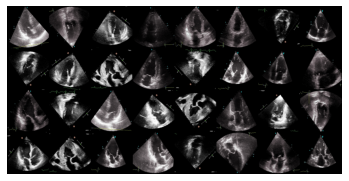

image size:  torch.Size([3, 224, 224])
device: cuda
model: resnet50
---------------------------------------------------------------

Epoch 0 report: 
Train model
----------
Epoch 0 Step 59 ave_loss 2.8599
Epoch 0 Step 119 ave_loss 1.2892
Epoch 0 Step 179 ave_loss 1.2764
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.34      0.74      0.47       409
          3C       0.00      0.00      0.00       367
          4C       0.58      0.51      0.54       831

    accuracy                           0.45      1607
   macro avg       0.31      0.42      0.34      1607
weighted avg       0.39      0.45      0.40      1607



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---------------------------------------------------------------

Epoch 1 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Step 59 ave_loss 1.0982
Epoch 1 Step 119 ave_loss 0.9764
Epoch 1 Step 179 ave_loss 0.8750
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.20      0.18      0.19       409
          3C       0.25      0.20      0.22       367
          4C       0.68      0.79      0.73       831

    accuracy                           0.50      1607
   macro avg       0.38      0.39      0.38      1607
weighted avg       0.46      0.50      0.48      1607

---------------------------------------------------------------

Epoch 2 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Step 59 ave_loss 0.7817
Epoch 2 Step 119 ave_loss 0.7124
Epoch 2 Step 179 ave_loss 0.5848
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.38      1.00      0.55       409
          3C       0.40      0.35      0.37       367
          4C       1.00      0.25      0.40       831

    accuracy                           0.47      1607
   macro avg       0.59      0.53      0.44      1607
weighted avg       0.71      0.47      0.43      1607

---------------------------------------------------------------

Epoch 3 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Step 59 ave_loss 0.4896
Epoch 3 Step 119 ave_loss 0.4716
Epoch 3 Step 179 ave_loss 0.3401
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.53      0.76      0.62       409
          3C       0.34      0.70      0.46       367
          4C       0.98      0.32      0.49       831

    accuracy                           0.52      1607
   macro avg       0.62      0.59      0.52      1607
weighted avg       0.72      0.52      0.52      1607

---------------------------------------------------------------

Epoch 4 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Step 59 ave_loss 0.2732
Epoch 4 Step 119 ave_loss 0.3087
Epoch 4 Step 179 ave_loss 0.2294
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.53      0.79      0.64       409
          3C       0.52      0.74      0.61       367
          4C       0.98      0.57      0.72       831

    accuracy                           0.66      1607
   macro avg       0.68      0.70      0.66      1607
weighted avg       0.76      0.66      0.67      1607

---------------------------------------------------------------

Epoch 5 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Step 59 ave_loss 0.1730
Epoch 5 Step 119 ave_loss 0.1331
Epoch 5 Step 179 ave_loss 0.1406
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       1.00      0.09      0.16       409
          3C       1.00      0.01      0.01       367
          4C       0.53      1.00      0.69       831

    accuracy                           0.54      1607
   macro avg       0.84      0.36      0.29      1607
weighted avg       0.76      0.54      0.40      1607

---------------------------------------------------------------

Epoch 6 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Step 59 ave_loss 0.1383
Epoch 6 Step 119 ave_loss 0.1277
Epoch 6 Step 179 ave_loss 0.0993
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.40      1.00      0.57       409
          3C       0.78      0.36      0.49       367
          4C       0.94      0.48      0.63       831

    accuracy                           0.58      1607
   macro avg       0.71      0.61      0.56      1607
weighted avg       0.77      0.58      0.58      1607

---------------------------------------------------------------

Epoch 7 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Step 59 ave_loss 0.1485
Epoch 7 Step 119 ave_loss 0.0927
Epoch 7 Step 179 ave_loss 0.0926
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.41      1.00      0.59       409
          3C       0.90      0.49      0.63       367
          4C       0.96      0.49      0.65       831

    accuracy                           0.62      1607
   macro avg       0.76      0.66      0.62      1607
weighted avg       0.81      0.62      0.63      1607

---------------------------------------------------------------

Epoch 8 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Step 59 ave_loss 0.1233
Epoch 8 Step 119 ave_loss 0.0787
Epoch 8 Step 179 ave_loss 0.0958
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.59      0.97      0.74       409
          3C       0.77      0.66      0.71       367
          4C       0.96      0.71      0.81       831

    accuracy                           0.77      1607
   macro avg       0.77      0.78      0.75      1607
weighted avg       0.82      0.77      0.77      1607

---------------------------------------------------------------

Epoch 9 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Step 59 ave_loss 0.0873
Epoch 9 Step 119 ave_loss 0.0627
Epoch 9 Step 179 ave_loss 0.0487
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.81      0.73      0.77       409
          3C       0.59      0.81      0.68       367
          4C       0.98      0.86      0.91       831

    accuracy                           0.81      1607
   macro avg       0.79      0.80      0.79      1607
weighted avg       0.84      0.81      0.82      1607

---------------------------------------------------------------

Epoch 10 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Step 59 ave_loss 0.0509
Epoch 10 Step 119 ave_loss 0.0622
Epoch 10 Step 179 ave_loss 0.0588
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.60      0.53      0.56       409
          3C       0.63      0.81      0.71       367
          4C       0.85      0.79      0.82       831

    accuracy                           0.73      1607
   macro avg       0.69      0.71      0.70      1607
weighted avg       0.74      0.73      0.73      1607

---------------------------------------------------------------

Epoch 11 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Step 59 ave_loss 0.0577
Epoch 11 Step 119 ave_loss 0.0473
Epoch 11 Step 179 ave_loss 0.0490
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.55      0.85      0.67       409
          3C       0.69      0.79      0.74       367
          4C       0.94      0.63      0.75       831

    accuracy                           0.72      1607
   macro avg       0.73      0.76      0.72      1607
weighted avg       0.78      0.72      0.73      1607

---------------------------------------------------------------

Epoch 12 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Step 59 ave_loss 0.0398
Epoch 12 Step 119 ave_loss 0.0242
Epoch 12 Step 179 ave_loss 0.0416
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.57      0.73      0.64       409
          3C       0.56      0.80      0.66       367
          4C       0.96      0.65      0.78       831

    accuracy                           0.70      1607
   macro avg       0.70      0.73      0.69      1607
weighted avg       0.77      0.70      0.71      1607

---------------------------------------------------------------

Epoch 13 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Step 59 ave_loss 0.0226
Epoch 13 Step 119 ave_loss 0.0467
Epoch 13 Step 179 ave_loss 0.0668
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.89      0.10      0.18       409
          3C       0.50      0.56      0.53       367
          4C       0.64      0.89      0.75       831

    accuracy                           0.62      1607
   macro avg       0.68      0.52      0.49      1607
weighted avg       0.67      0.62      0.55      1607

---------------------------------------------------------------

Epoch 14 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Step 59 ave_loss 0.0178
Epoch 14 Step 119 ave_loss 0.0164
Epoch 14 Step 179 ave_loss 0.0127
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.61      0.76      0.67       409
          3C       0.64      0.81      0.71       367
          4C       0.98      0.75      0.85       831

    accuracy                           0.77      1607
   macro avg       0.74      0.77      0.75      1607
weighted avg       0.81      0.77      0.78      1607

---------------------------------------------------------------

Epoch 15 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Step 59 ave_loss 0.0264
Epoch 15 Step 119 ave_loss 0.0227
Epoch 15 Step 179 ave_loss 0.0189
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.61      0.79      0.69       409
          3C       0.64      0.73      0.68       367
          4C       0.98      0.77      0.86       831

    accuracy                           0.77      1607
   macro avg       0.74      0.76      0.74      1607
weighted avg       0.81      0.77      0.77      1607

---------------------------------------------------------------

Epoch 16 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Step 59 ave_loss 0.0252
Epoch 16 Step 119 ave_loss 0.0430
Epoch 16 Step 179 ave_loss 0.0096
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.66      0.77      0.71       409
          3C       0.62      0.77      0.69       367
          4C       0.98      0.79      0.88       831

    accuracy                           0.78      1607
   macro avg       0.75      0.78      0.76      1607
weighted avg       0.82      0.78      0.79      1607

---------------------------------------------------------------

Epoch 17 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Step 59 ave_loss 0.0097
Epoch 17 Step 119 ave_loss 0.0118
Epoch 17 Step 179 ave_loss 0.0140
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.63      0.76      0.69       409
          3C       0.63      0.72      0.67       367
          4C       0.96      0.80      0.87       831

    accuracy                           0.77      1607
   macro avg       0.74      0.76      0.74      1607
weighted avg       0.80      0.77      0.78      1607

---------------------------------------------------------------

Epoch 18 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Step 59 ave_loss 0.0259
Epoch 18 Step 119 ave_loss 0.0176
Epoch 18 Step 179 ave_loss 0.0218
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.60      0.69      0.64       409
          3C       0.41      0.85      0.56       367
          4C       0.99      0.46      0.63       831

    accuracy                           0.61      1607
   macro avg       0.67      0.67      0.61      1607
weighted avg       0.76      0.61      0.62      1607

---------------------------------------------------------------

Epoch 19 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Step 59 ave_loss 0.0277
Epoch 19 Step 119 ave_loss 0.0174
Epoch 19 Step 179 ave_loss 0.0295
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.60      0.92      0.73       409
          3C       0.81      0.77      0.78       367
          4C       0.96      0.74      0.83       831

    accuracy                           0.79      1607
   macro avg       0.79      0.81      0.78      1607
weighted avg       0.83      0.79      0.80      1607

model: resnet50 , size: 224 , augmentation: aug
accr:  [45, 49, 46, 52, 66, 54, 58, 61, 76, 81, 73, 72, 70, 61, 76, 76, 78, 77, 60, 78]
loss:  [0.9563, 0.8458, 0.4607, 0.3057, 0.0909, 0.0695, 0.0073, 0.1075, 0.0187, 0.0379, 0.0051, 0.0065, 0.0001, 0.0085, 0.0004, 0.001, 0.0026, 0.0074, 0.0472, 0.0017]
Number of Image in train set: 6717
Number of Image in test set: 1607
Num batch in train set:  210
Num batch in test set:  51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['2C', '3C', '3C', '3C', '4C', '3C', '3C', '2C']
['4C', '4C', '2C', '4C', '2C', '2C', '2C', '2C']
['3C', '4C', '4C', '2C', '3C', '4C', '4C', '3C']
['2C', '2C', '3C', '4C', '2C', '2C', '2C', '3C']


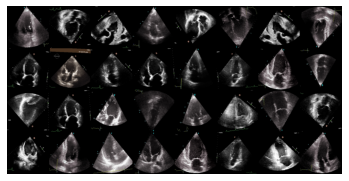

image size:  torch.Size([3, 224, 224])
device: cuda
model: densenet121
---------------------------------------------------------------

Epoch 0 report: 
Train model
----------
Epoch 0 Step 59 ave_loss 1.0799
Epoch 0 Step 119 ave_loss 0.7760
Epoch 0 Step 179 ave_loss 0.6269
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.67      0.71      0.69       409
          3C       0.36      0.77      0.49       367
          4C       0.99      0.47      0.64       831

    accuracy                           0.60      1607
   macro avg       0.67      0.65      0.61      1607
weighted avg       0.77      0.60      0.62      1607

---------------------------------------------------------------

Epoch 1 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Step 59 ave_loss 0.3393
Epoch 1 Step 119 ave_loss 0.2789
Epoch 1 Step 179 ave_loss 0.2492
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.61      0.86      0.71       409
          3C       1.00      0.22      0.35       367
          4C       0.71      0.82      0.76       831

    accuracy                           0.69      1607
   macro avg       0.78      0.63      0.61      1607
weighted avg       0.75      0.69      0.66      1607

---------------------------------------------------------------

Epoch 2 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Step 59 ave_loss 0.1463
Epoch 2 Step 119 ave_loss 0.1529
Epoch 2 Step 179 ave_loss 0.1451
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.61      0.81      0.70       409
          3C       0.75      0.54      0.63       367
          4C       0.78      0.75      0.77       831

    accuracy                           0.72      1607
   macro avg       0.72      0.70      0.70      1607
weighted avg       0.73      0.72      0.72      1607

---------------------------------------------------------------

Epoch 3 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Step 59 ave_loss 0.1149
Epoch 3 Step 119 ave_loss 0.0827
Epoch 3 Step 179 ave_loss 0.0631
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.63      0.79      0.70       409
          3C       0.56      0.90      0.69       367
          4C       0.98      0.60      0.74       831

    accuracy                           0.71      1607
   macro avg       0.72      0.76      0.71      1607
weighted avg       0.80      0.71      0.72      1607

---------------------------------------------------------------

Epoch 4 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Step 59 ave_loss 0.0464
Epoch 4 Step 119 ave_loss 0.0524
Epoch 4 Step 179 ave_loss 0.0448
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.55      0.77      0.64       409
          3C       0.74      0.77      0.75       367
          4C       0.89      0.70      0.79       831

    accuracy                           0.73      1607
   macro avg       0.73      0.74      0.73      1607
weighted avg       0.77      0.73      0.74      1607

---------------------------------------------------------------

Epoch 5 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Step 59 ave_loss 0.0621
Epoch 5 Step 119 ave_loss 0.0453
Epoch 5 Step 179 ave_loss 0.0500
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.50      0.88      0.64       409
          3C       0.78      0.77      0.77       367
          4C       0.95      0.60      0.73       831

    accuracy                           0.71      1607
   macro avg       0.74      0.75      0.71      1607
weighted avg       0.79      0.71      0.72      1607

---------------------------------------------------------------

Epoch 6 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Step 59 ave_loss 0.0267
Epoch 6 Step 119 ave_loss 0.0180
Epoch 6 Step 179 ave_loss 0.0156
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.48      0.95      0.63       409
          3C       0.64      0.65      0.65       367
          4C       1.00      0.51      0.67       831

    accuracy                           0.65      1607
   macro avg       0.71      0.70      0.65      1607
weighted avg       0.79      0.65      0.66      1607

---------------------------------------------------------------

Epoch 7 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Step 59 ave_loss 0.0181
Epoch 7 Step 119 ave_loss 0.0237
Epoch 7 Step 179 ave_loss 0.0351
Test model
----------

Evaluation completed in 0m 14s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.81      0.72      0.76       409
          3C       0.72      0.75      0.73       367
          4C       0.89      0.91      0.90       831

    accuracy                           0.83      1607
   macro avg       0.80      0.80      0.80      1607
weighted avg       0.83      0.83      0.83      1607

---------------------------------------------------------------

Epoch 8 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Step 59 ave_loss 0.0143
Epoch 8 Step 119 ave_loss 0.0163
Epoch 8 Step 179 ave_loss 0.0191
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.95      0.75      0.84       409
          3C       0.66      0.86      0.74       367
          4C       0.87      0.84      0.86       831

    accuracy                           0.82      1607
   macro avg       0.83      0.82      0.81      1607
weighted avg       0.84      0.82      0.83      1607

---------------------------------------------------------------

Epoch 9 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Step 59 ave_loss 0.0211
Epoch 9 Step 119 ave_loss 0.0516
Epoch 9 Step 179 ave_loss 0.0569
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.84      0.72      0.77       409
          3C       0.64      0.94      0.76       367
          4C       0.97      0.84      0.90       831

    accuracy                           0.83      1607
   macro avg       0.82      0.83      0.81      1607
weighted avg       0.86      0.83      0.84      1607

---------------------------------------------------------------

Epoch 10 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Step 59 ave_loss 0.0084
Epoch 10 Step 119 ave_loss 0.0079
Epoch 10 Step 179 ave_loss 0.0099
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.68      0.81      0.74       409
          3C       0.70      0.80      0.74       367
          4C       0.95      0.80      0.87       831

    accuracy                           0.80      1607
   macro avg       0.78      0.80      0.78      1607
weighted avg       0.82      0.80      0.81      1607

---------------------------------------------------------------

Epoch 11 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Step 59 ave_loss 0.0416
Epoch 11 Step 119 ave_loss 0.0129
Epoch 11 Step 179 ave_loss 0.0039
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.82      0.76       409
          3C       0.62      0.92      0.74       367
          4C       1.00      0.71      0.83       831

    accuracy                           0.78      1607
   macro avg       0.77      0.82      0.78      1607
weighted avg       0.84      0.78      0.79      1607

---------------------------------------------------------------

Epoch 12 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Step 59 ave_loss 0.0155
Epoch 12 Step 119 ave_loss 0.0185
Epoch 12 Step 179 ave_loss 0.0073
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.59      0.83      0.69       409
          3C       0.60      0.86      0.71       367
          4C       0.99      0.61      0.76       831

    accuracy                           0.72      1607
   macro avg       0.73      0.77      0.72      1607
weighted avg       0.80      0.72      0.73      1607

---------------------------------------------------------------

Epoch 13 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Step 59 ave_loss 0.0145
Epoch 13 Step 119 ave_loss 0.0121
Epoch 13 Step 179 ave_loss 0.0051
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.60      0.82      0.69       409
          3C       0.57      0.85      0.69       367
          4C       1.00      0.61      0.76       831

    accuracy                           0.72      1607
   macro avg       0.72      0.76      0.71      1607
weighted avg       0.80      0.72      0.72      1607

---------------------------------------------------------------

Epoch 14 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Step 59 ave_loss 0.0057
Epoch 14 Step 119 ave_loss 0.0191
Epoch 14 Step 179 ave_loss 0.0243
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.60      0.80      0.69       409
          3C       0.50      0.92      0.65       367
          4C       1.00      0.47      0.64       831

    accuracy                           0.66      1607
   macro avg       0.70      0.73      0.66      1607
weighted avg       0.78      0.66      0.65      1607

---------------------------------------------------------------

Epoch 15 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Step 59 ave_loss 0.0113
Epoch 15 Step 119 ave_loss 0.0102
Epoch 15 Step 179 ave_loss 0.0033
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.64      0.77      0.70       409
          3C       0.58      0.79      0.67       367
          4C       0.94      0.70      0.80       831

    accuracy                           0.74      1607
   macro avg       0.72      0.75      0.72      1607
weighted avg       0.78      0.74      0.75      1607

---------------------------------------------------------------

Epoch 16 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Step 59 ave_loss 0.0079
Epoch 16 Step 119 ave_loss 0.0077
Epoch 16 Step 179 ave_loss 0.0105
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.58      0.80      0.68       409
          3C       0.55      0.97      0.70       367
          4C       0.99      0.47      0.64       831

    accuracy                           0.67      1607
   macro avg       0.71      0.75      0.67      1607
weighted avg       0.79      0.67      0.66      1607

---------------------------------------------------------------

Epoch 17 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Step 59 ave_loss 0.0072
Epoch 17 Step 119 ave_loss 0.0030
Epoch 17 Step 179 ave_loss 0.0023
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.62      0.78      0.69       409
          3C       0.68      0.95      0.79       367
          4C       0.96      0.67      0.79       831

    accuracy                           0.76      1607
   macro avg       0.75      0.80      0.76      1607
weighted avg       0.81      0.76      0.76      1607

---------------------------------------------------------------

Epoch 18 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Step 59 ave_loss 0.0113
Epoch 18 Step 119 ave_loss 0.0073
Epoch 18 Step 179 ave_loss 0.0201
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.68      0.77      0.72       409
          3C       0.63      0.86      0.72       367
          4C       0.97      0.76      0.85       831

    accuracy                           0.78      1607
   macro avg       0.76      0.79      0.77      1607
weighted avg       0.82      0.78      0.79      1607

---------------------------------------------------------------

Epoch 19 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Step 59 ave_loss 0.0067
Epoch 19 Step 119 ave_loss 0.0050
Epoch 19 Step 179 ave_loss 0.0079
Test model
----------

Evaluation completed in 0m 15s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.57      0.77      0.66       409
          3C       0.56      0.93      0.70       367
          4C       0.97      0.52      0.67       831

    accuracy                           0.68      1607
   macro avg       0.70      0.74      0.68      1607
weighted avg       0.77      0.68      0.67      1607

model: densenet121 , size: 224 , augmentation: aug
accr:  [59, 69, 71, 71, 73, 70, 65, 82, 82, 83, 80, 78, 72, 71, 65, 73, 67, 76, 78, 67]
loss:  [0.5554, 0.136, 0.1359, 0.0257, 0.0496, 0.0076, 0.0029, 0.008, 0.0019, 0.0249, 0.009, 0.0025, 0.007, 0.0119, 0.0152, 0.0025, 0.0008, 0.0026, 0.0015, 0.0022]


In [9]:
modelset = ['vgg16', 'resnet18', 'resnet50', 'densenet121']

for i in modelset:
  model = run(modelName=i, imgSize=224, aug="aug")

# Demo mô hình với video

In [12]:
def run_video(modelName = 'vgg16'):
  print(modelName)
  transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])
  sample_data = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/test', 
      transform=transform_test)
  videotest = namedtuple('videotest', ['id', "ytrues", 'ypreds'])
  id_video = []

  for i, image in enumerate(sample_data.imgs):
    id_video.append(image[0].split("/")[-1].split("_")[0])
  
  video_list = []
  for image in id_video:
    if (image in video_list) == False:
      video_list.append(image)
    else:
      pass

  ytrue = []
  ypred = []

  if modelName == 'vgg16':
    modelload = torchvision.models.vgg16(pretrained=False)
    modelload.classifier[6] = torch.nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('vgg16.pth'), strict=False)
  elif modelName == "resnet50":
    modelload = torchvision.models.resnet50(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True) 
    modelload.load_state_dict(torch.load('resnet50.pth'), strict=False)
  elif modelName == "resnet18":
    modelload = torchvision.models.resnet18(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=512, out_features=3, bias=True) 
    modelload.load_state_dict(torch.load('resnet18.pth'), strict=False)
  else:
    modelload = torchvision.models.densenet121(pretrained=False)
    modelload.classifier = torch.nn.modules.linear.Linear(in_features=1024, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('densenet121.pth'), strict=False)

  modelload.to('cuda')
  modelload.eval()
  for image, label in sample_data:
    image = image.unsqueeze(0).to('cuda')
    output = modelload(image)
    _, predicted = torch.max(output, dim=1)
    ytrue.append(label)
    ypred += list(predicted.cpu().numpy())

  outputs_video = []
  ytrue_video = []
  ypred_video = []
  index = 0
  for id in video_list:
    index += 1
    vtrue = []
    vpred = []
    for i, img in enumerate(id_video):
      if img == id:
        vtrue.append(ytrue[i])
        vpred.append(ypred[i])

    rate_true = [0, 0, 0]
    rate_pred = [0, 0, 0]
    for label in range(3):
      rate_true[label] = list(vtrue).count(label)
      rate_pred[label] = list(vpred).count(label)

    labeltrue = np.argmax(rate_true)
    labelpred = np.argmax(rate_pred)

    if index %4 != 0:
      print("id: ", id, ", true:", labeltrue, ", pred: ", labelpred, end="  |  ")
    else: print("id: ", id, ", true:", labeltrue, ", pred: ", labelpred)
    ytrue_video.append(labeltrue)
    ypred_video.append(labelpred)
    outputs_video.append(videotest(id=id,ytrues=labeltrue,ypreds=labelpred))
  print(classification_report(ytrue_video, ypred_video, target_names=classes))
  return outputs_video

In [13]:
# result = run_video('vgg16')
for i in modelset:
  result = run_video(modelName=i)

vgg16
id:  158 , true: 0 , pred:  0  |  id:  165 , true: 0 , pred:  0  |  id:  168 , true: 0 , pred:  0  |  id:  169 , true: 0 , pred:  0
id:  171 , true: 0 , pred:  0  |  id:  176 , true: 0 , pred:  0  |  id:  177 , true: 0 , pred:  0  |  id:  178 , true: 0 , pred:  0
id:  181 , true: 0 , pred:  0  |  id:  183 , true: 0 , pred:  0  |  id:  191 , true: 0 , pred:  0  |  id:  192 , true: 0 , pred:  0
id:  157 , true: 1 , pred:  1  |  id:  159 , true: 1 , pred:  1  |  id:  161 , true: 1 , pred:  1  |  id:  162 , true: 1 , pred:  1
id:  166 , true: 1 , pred:  1  |  id:  174 , true: 1 , pred:  1  |  id:  175 , true: 1 , pred:  1  |  id:  179 , true: 1 , pred:  1
id:  185 , true: 1 , pred:  1  |  id:  186 , true: 1 , pred:  1  |  id:  189 , true: 1 , pred:  1  |  id:  190 , true: 1 , pred:  1
id:  194 , true: 1 , pred:  1  |  id:  160 , true: 2 , pred:  2  |  id:  163 , true: 2 , pred:  2  |  id:  164 , true: 2 , pred:  2
id:  167 , true: 2 , pred:  2  |  id:  170 , true: 2 , pred:  2  |  id

In [14]:
# for i in range(len(result)):
#   if (i+1)%3!=0:
#     print(result[i], end="  |  ")
#   else: print(result[i])

In [15]:
import pandas as pd
def demo_frame(modelName='vgg16'):
  print(modelName)
  transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])
  sample_data = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/test', 
      transform=transform_test)
  filename = []
  for i, image in enumerate(sample_data.imgs):
    filename.append(image[0].split("/")[-1])
    # print(image[0].split("/")[-1])
  if modelName == 'vgg16':
    modelload = torchvision.models.vgg16(pretrained=False)
    modelload.classifier[6] = torch.nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('vgg16.pth'), strict=False)
  elif modelName == "resnet50":
    modelload = torchvision.models.resnet50(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True) 
    modelload.load_state_dict(torch.load('resnet50.pth'), strict=False)
  elif modelName == "resnet18":
    modelload = torchvision.models.resnet18(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=512, out_features=3, bias=True) 
    modelload.load_state_dict(torch.load('resnet18.pth'), strict=False)
  else:
    modelload = torchvision.models.densenet121(pretrained=False)
    modelload.classifier = torch.nn.modules.linear.Linear(in_features=1024, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('densenet121.pth'), strict=False)

  modelload.to('cuda')
  modelload.eval()
  ypred = []
  for image, label in sample_data:
      image = image.unsqueeze(0).to('cuda')
      output = modelload(image)
      _, predicted = torch.max(output, dim=1)
      ypred += list(predicted.cpu().numpy())
  classes0 = {'2C':0 , '3C':1, '4C':2}
  classes0 = dict((v,k) for k,v in classes0.items())
  predictions = [classes0[k] for k in ypred]
  result0 = pd.DataFrame({"Filename":filename, "Prediction":predictions})
  results_file = "./" + modelName + "_results.csv"
  result0.to_csv(results_file,index=False)

In [16]:
for i in modelset:
  result = demo_frame(modelName=i)

vgg16
resnet18
resnet50
densenet121
